# Part 1

### Location Scale-t - Normal - Half Normal - Discrete Uniform Specification

In [68]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

In [69]:
# Set seed
np.random.seed(1006080367)

# Initialize Prior Hyperparameters
mu_0, sigma_0 = 0, 10 # Normal-Prior for mu (location parameter)
sigma_1 = 5 # Half Normal Prior for tau (scale parameter)
l, u = 1, 101 # Discrete Uniform Prior for nu (df parameter)


# True values that the data will be from, IRL, we don't knnow these values
N, loc_true, scale_true, df_true = 100, 10, 2, 15
# Generate observations
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(N)


t_norm_half_norm_discrete = pm.Model()

with t_norm_half_norm_discrete:
    loc = pm.Normal("loc", mu = mu_0, sigma = sigma_0)
    scale = pm.HalfNormal("scale", sigma = sigma_1)
    df = pm.DiscreteUniform("df", lower = l, upper = u)
    x_obs = pm.StudentT("likelihood", mu = loc, sigma = scale, nu = df, observed=x)

In [70]:
with t_norm_half_norm_discrete:
    idata_HMC = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Split-Rhats {'loc': 1.0016, 'df': 1.0032, 'scale': 1.0016}
# of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,10.00,0.26,9.47,10.46,0.00,0.00,3748.25,2511.67,1.0
df,50.71,28.79,7.00,98.00,1.08,0.76,651.89,456.81,1.0
scale,2.50,0.21,2.09,2.89,0.01,0.00,1533.26,1139.95,1.0


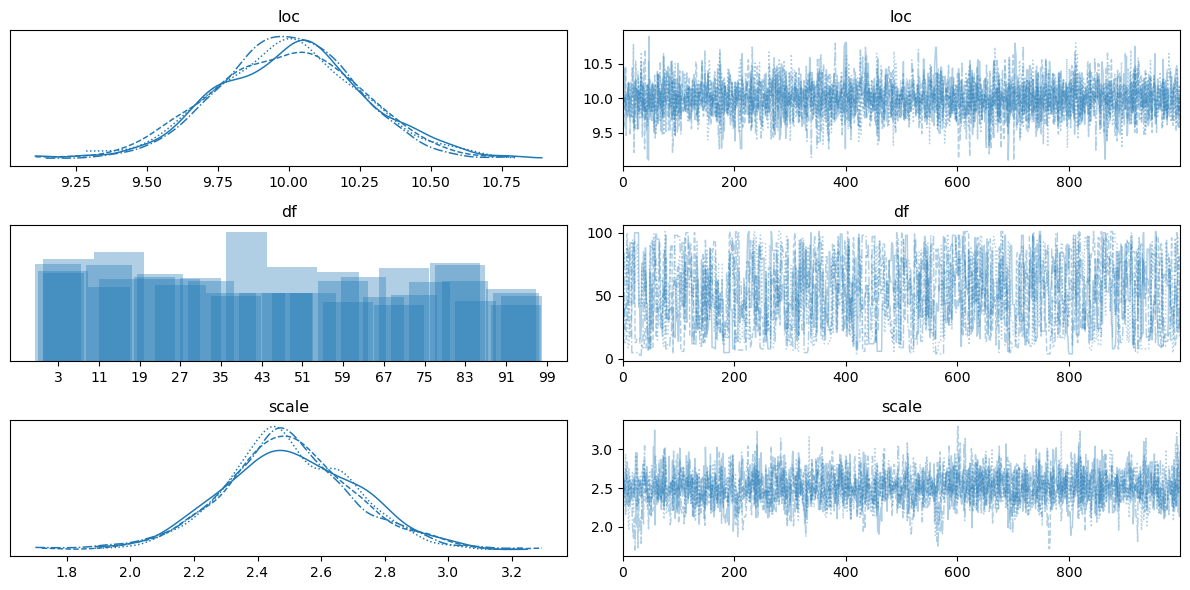

In [71]:
# Draw trace plots and distributions, and show Split-Rhat values
az.plot_trace(idata_HMC)
plt.tight_layout()
print("Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})
print("# of MCMC samples:", idata_HMC.posterior['df'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

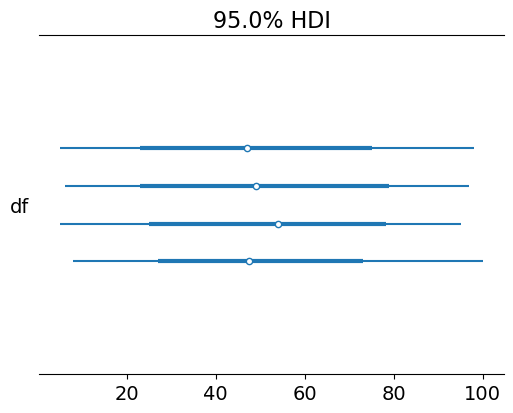

In [72]:
# Plot HDI
az.plot_forest(idata_HMC, var_names=["df"], combined=False, hdi_prob=0.95)

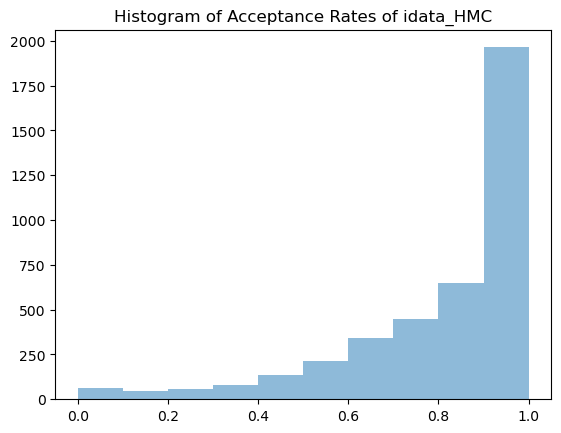

In [90]:
plt.hist(idata_HMC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of idata_HMC');

Autocorrelation for HMC (MCMC) chain 0.7111244297225481


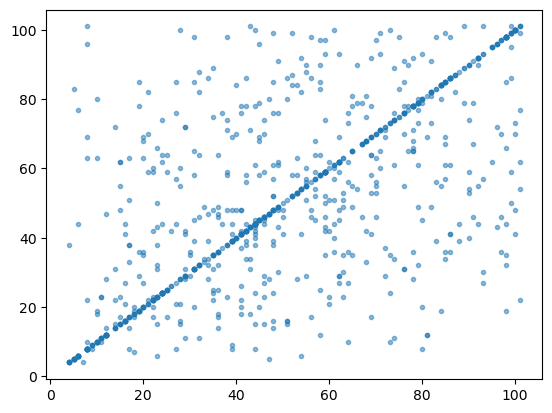

In [73]:
#
fig,ax = plt.subplots(1,1)
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["df"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata_HMC.posterior["df"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values;
ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

##### By looking at the distribution of the $\nu$ parameter, we can say that we are rather uncertain about it's true value. With only 100 samples, it is almost impossible to say where the true parameter $\nu$ lies and thus we have very little inference about it. The distribution looks like a uniform distribution, suggesting that any $\nu$ value from 3-99 is equally probable and that the inference is flat. Although the Rhat values imply convergence, we can clearly look at that standard deviation of the chain and see that $\nu$ has a value of 28.20. This is way higher than the other parameters' deviations, being 0.26 and 0.20. Since $\nu$ measures the thickness of the tails,we see that it is only 687 which suggests that the MCMC samples are not very informative for posterior analysis. This suggests that the chains might be exhibiting some autocorrelation. This is pretty much proven by looking at the autocorrelation plot which shows demonstrates that the chain has a correlation of 0.71. The HDI plot also shows that the 95% credible interval are wide and not very reliable. Finally, the acceptance rates for the proposal distribution is rather high. We would need more samples to see better inferences for $\nu$.There are no divergences in the simulated trials. 

- The only warning: The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation.

### Increase number of samples from 100 $\rarr$ 10000 to see how it changes the inference of the df parameter, $\nu$

In [79]:
# Initialize Prior Hyperparameters
mu_0, sigma_0 = 0, 10 # Normal-Prior for mu (location parameter)
sigma_1 = 5 # Half Normal Prior for tau (scale parameter)
l, u = 1, 101 # Discrete Uniform Prior for nu (df parameter)


# True values that the data will be from, IRL, we don't knnow these values
N, loc_true, scale_true, df_true = 10000, 10, 2, 15
# Generate observations
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(N)


t_norm_half_norm_discrete = pm.Model()

with t_norm_half_norm_discrete:
    loc = pm.Normal("loc", mu = mu_0, sigma = sigma_0)
    scale = pm.HalfNormal("scale", sigma = sigma_1)
    df = pm.DiscreteUniform("df", lower = l, upper = u)
    x_obs = pm.StudentT("likelihood", mu = loc, sigma = scale, nu = df, observed=x)
    idata = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [loc, scale]
>Metropolis: [df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Split-Rhats {'loc': 1.0018, 'df': 1.0031, 'scale': 1.0017}
# of MCMC samples: 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,9.99,0.02,9.95,10.03,0.00,0.00,3314.80,2446.19,1.0
df,17.83,2.89,13.00,23.00,0.15,0.11,368.90,541.27,1.0
scale,2.03,0.02,1.99,2.08,0.00,0.00,521.77,866.61,1.0


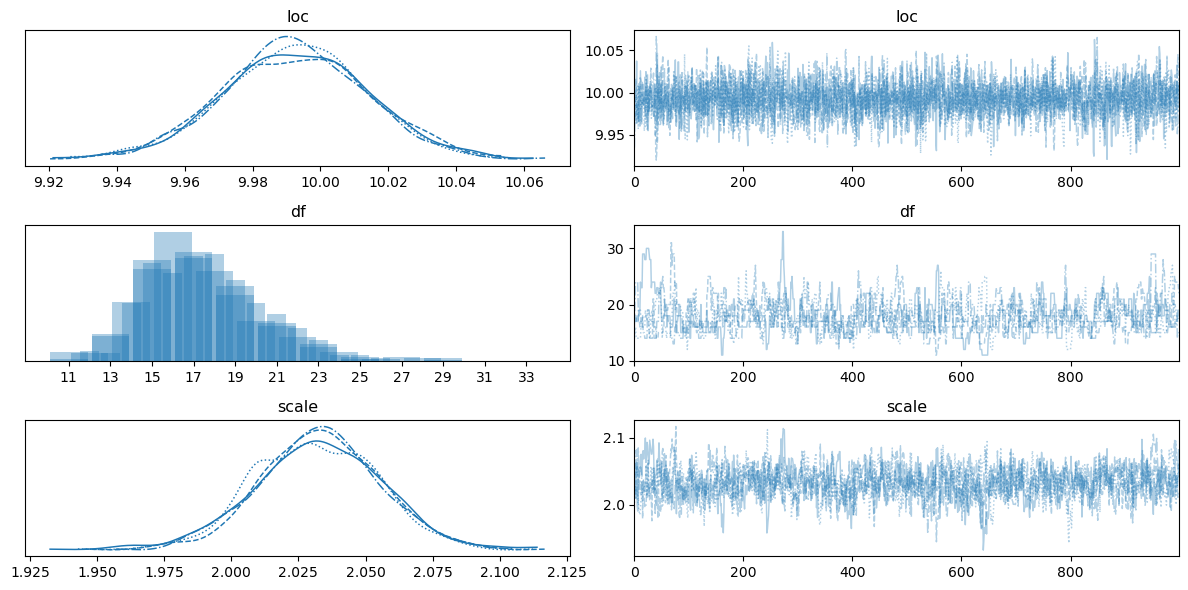

In [85]:
# Draw trace plots and distributions, and show Split-Rhat values
az.plot_trace(idata)
plt.tight_layout()
print("Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items()})
print("# of MCMC samples:", idata.posterior['df'].values.flatten().shape[-1])
az.summary(idata, round_to=2)

c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\shahr\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

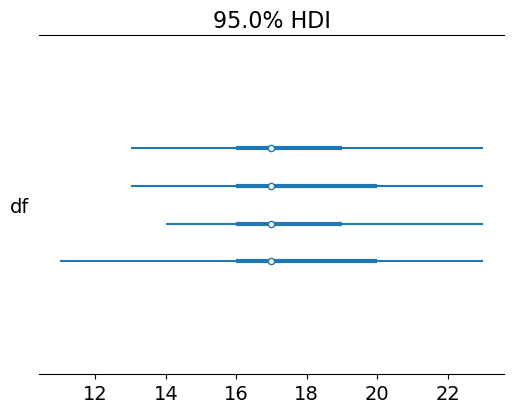

In [87]:
az.plot_forest(idata, var_names=["df"], combined=False, hdi_prob=0.95)

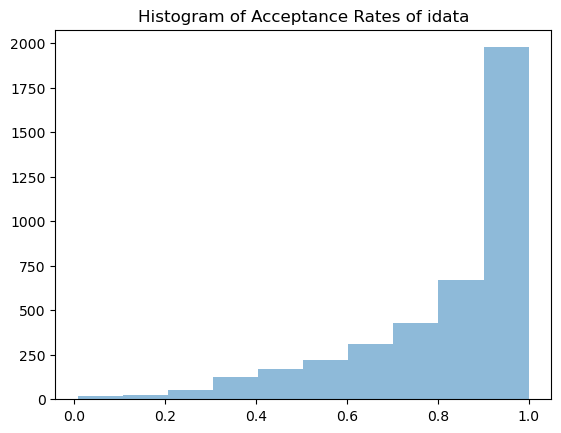

In [91]:
plt.hist(idata.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of idata');

Autocorrelation for HMC (MCMC) chain 0.8867025213907289


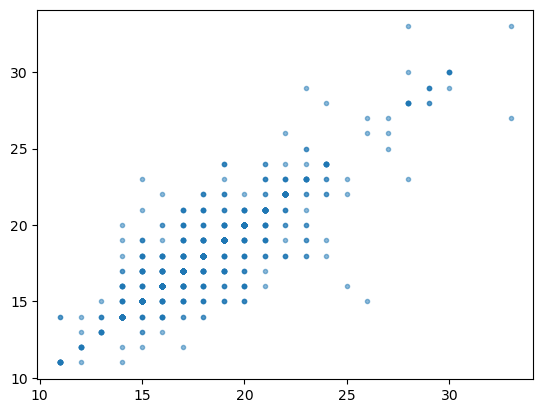

In [84]:
fig,ax = plt.subplots(1,1)
max_mcmc_samples = 1000
mcmc_chain = idata.posterior["df"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead = idata.posterior["df"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values;
ax.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

##### With more samples, the standard deviation for the df parameter is 2.89, which is smaller than the previous summary shown above. This reflects a tighter distribution around the mean and suggests a decrease in uncertainty about the df estimates. The 94% HDI for the df parameter is from 13.00 to 23.00, which encompasses the true value (df_true = 15). This interval is narrower than in the previous summary, indicating increased precision in the posterior estimation. This is also seen in the distribution plot of df, as it peaks around 15-18, which suggests the inference with more samples is much better than before. Despite the increase in the total number of observations, the effective sample sizes (ess_bulk and ess_tail) have decreased compared to the previous summary. This could indicate higher autocorrelation within the MCMC chains despite having more data, and looking at the autocorrelation plot confirms this as there is a correlation of 0.88. More samples can sometimes lead to clearer patterns of autocorrelation, which may reduce the effective sample size. It's also possible that the posterior space is complex, and this could lead to slower mixing and more autocorrelation in the chains. The split R-hat values also imply convergence, as they are less than 1.05. Finally, the acceptance rates for the proposal distribution are very high and thus we see a left-skewed distribution. which means Overall, more samples from the likelihood led to a better inference of the df parameter, but at the expense of high autocorrelated chains and computational time. There are no divergences in the simulated trials. 

- The only warning: The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation.

# Part 2 - Centered and Uncentered Eight Schools Models

## Centered

In [94]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

# Set up the model
with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

# Conduct PyMC simulation
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


##### Here we have 175 divergences. Compare this to the Location Scale-t - Normal - Half Normal - Discrete Uniform specification which has 0 divergences. This suggests that the posterior space is more complex and it may be possible to 'fall off' the distributional mass. As for warnings, PyMC suggests running 4 chains for robust computation of convergence diagnostics.

In [96]:
print("number of MCMC samples:", fit_C.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_C, round_to=2)

number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.19,3.29,-1.97,10.27,0.09,0.06,1307.64,1373.71,1.00
theta[0],6.28,5.88,-4.26,17.98,0.15,0.11,1341.48,3035.80,1.00
theta[1],4.88,4.81,-3.85,14.27,0.11,0.07,1807.62,4208.35,1.00
theta[2],3.63,5.53,-7.09,14.03,0.10,0.08,2715.02,3918.24,1.00
theta[3],4.63,5.04,-4.89,14.17,0.10,0.08,2149.42,3479.28,1.00
theta[4],3.30,4.82,-6.21,12.09,0.10,0.07,2156.42,4482.47,1.00
theta[5],3.78,4.89,-6.08,12.64,0.10,0.07,2400.18,4501.51,1.00
theta[6],6.36,5.29,-3.04,16.70,0.14,0.10,1255.98,2839.34,1.01
theta[7],4.71,5.56,-5.77,15.31,0.11,0.08,2209.49,3744.84,1.00
tau,4.07,3.20,0.70,9.86,0.14,0.10,141.33,43.02,1.01


##### Tau has the smallest effective sample size at 43, and most of the theta's range between 2800 - 4500. Since there are 10000 MCMC samples, these sizes suggest that there is significant autocorrelation in the chains. 

In [97]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()})

HMC Split-Rhats {'mu': 1.0021, 'theta': array([1.0047, 1.002 , 1.0017, 1.0015, 1.0014, 1.0023, 1.0056, 1.0025]), 'tau': 1.0097}


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

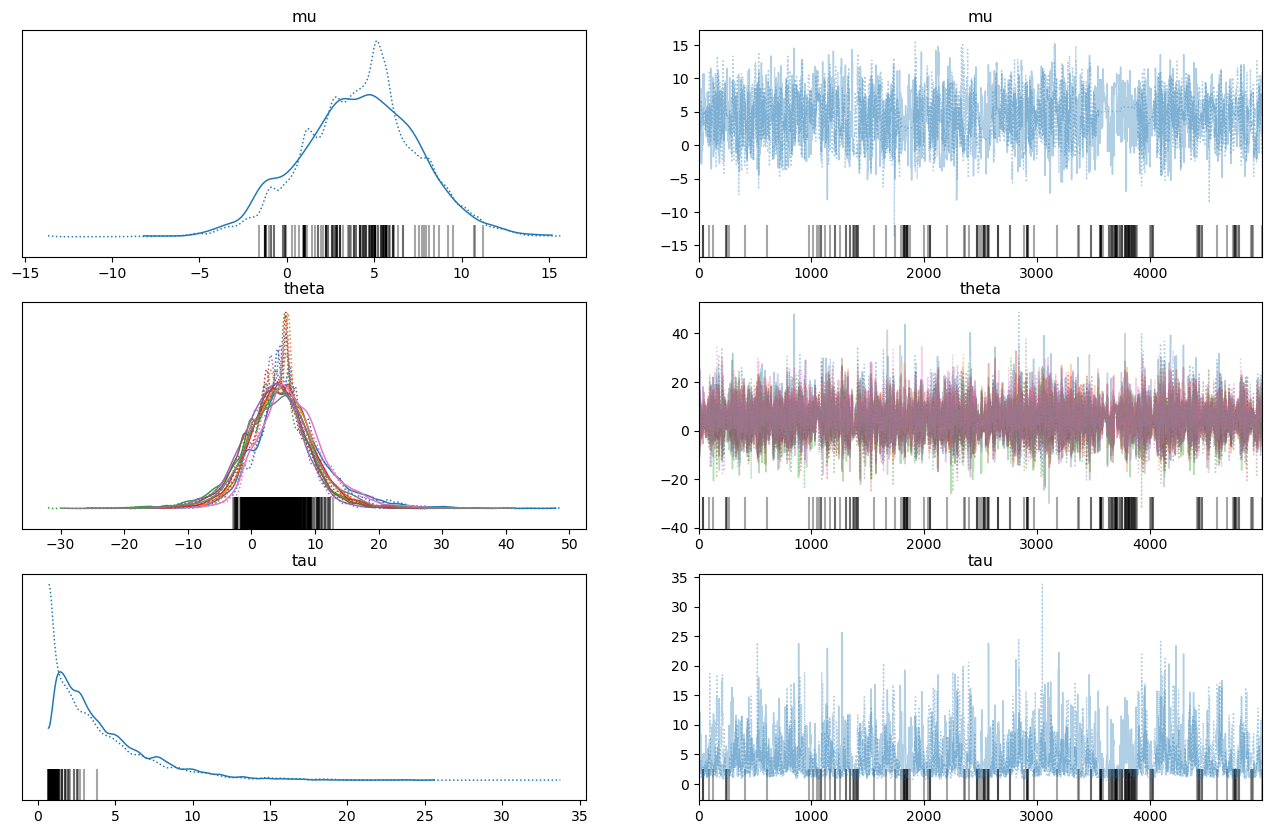

In [117]:
fig,ax = plt.subplots(3,2, figsize=(16,10))
az.plot_trace(fit_C, axes=ax[:3,:3])

##### All of the Split-Rhat values are < 1.05 which suggests all of the markov chains have converged

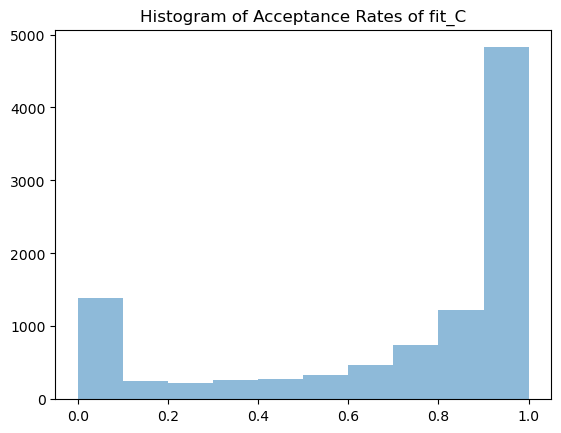

In [102]:
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of fit_C');

##### A lot of samples tend to be accepted by the proposal, as seen above. There is a slight left peak at 0, which may explain some of the divergence in the chain.

## Uncentered

In [113]:
with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


##### Here we have 4 divergences. Compare this to the centered specification which has 175 divergences. As for warnings, PyMC suggests running 4 chains for robust computation of convergence diagnostics.

In [114]:
print("number of MCMC samples:", fit_NC.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_NC, round_to=2

number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.36,3.29,-1.77,10.58,0.04,0.02,8689.99,5833.46,1.0
theta_t[0],0.32,0.99,-1.56,2.14,0.01,0.01,11496.72,7227.09,1.0
theta_t[1],0.09,0.93,-1.69,1.81,0.01,0.01,11394.19,7025.14,1.0
theta_t[2],-0.08,0.97,-1.97,1.71,0.01,0.01,15032.58,6810.16,1.0
theta_t[3],0.06,0.93,-1.74,1.79,0.01,0.01,12872.79,7410.10,1.0
theta_t[4],-0.15,0.95,-1.92,1.65,0.01,0.01,13547.02,6428.22,1.0
theta_t[5],-0.08,0.94,-1.90,1.67,0.01,0.01,14378.75,7362.24,1.0
theta_t[6],0.36,0.97,-1.41,2.21,0.01,0.01,10581.91,6749.08,1.0
theta_t[7],0.08,0.98,-1.80,1.85,0.01,0.01,12258.42,7296.02,1.0
tau,3.65,3.26,0.00,9.50,0.04,0.03,5250.31,4445.65,1.0


#### Most parameters have higher effective sample size under this model compared to the centered model. Notably, tau has increased its effective sample size by a huge margin, all theta's have effective sample sizes greater than the actual MCMC samples, which suggest that the autocorrelation is very very low.

In [115]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_NC).items()})

HMC Split-Rhats {'mu': 1.0007, 'theta_t': array([1.0001, 1.0003, 0.9999, 0.9999, 1.0002, 1.0004, 1.    , 1.0004]), 'tau': 1.0, 'theta': array([1.    , 0.9999, 1.0002, 1.0001, 1.0006, 1.0005, 1.    , 1.0001])}


##### All split-rhats are less than 1.05 and they are smaller than compared to the centered model. All the markov chains converge. 

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta_t'}>,
        <Axes: title={'center': 'theta_t'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

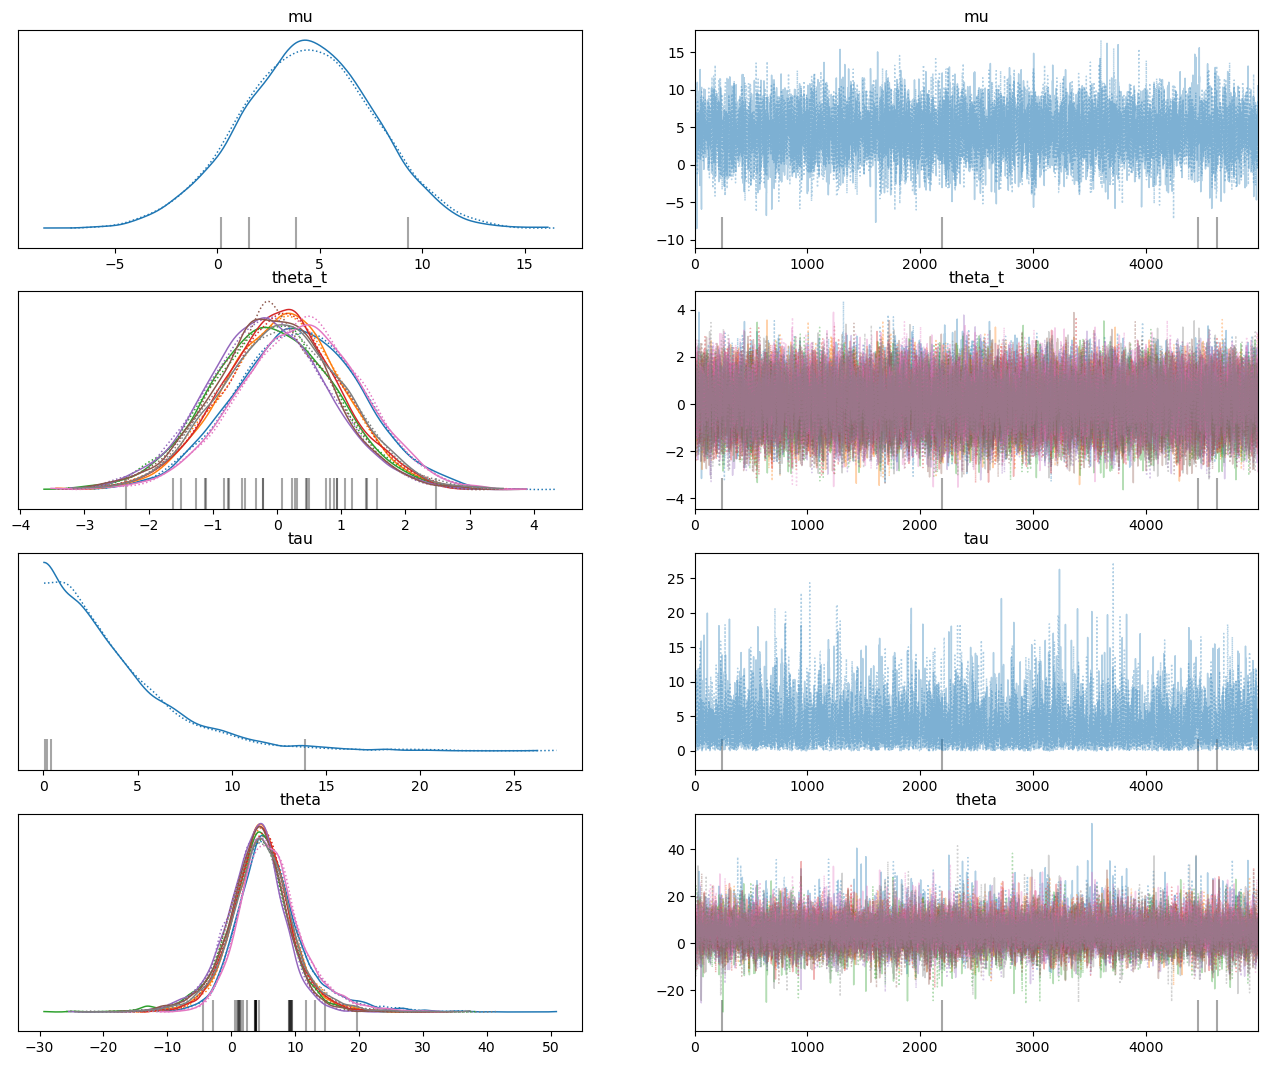

In [119]:
fig,ax = plt.subplots(4,2, figsize=(16,13))
az.plot_trace(fit_NC, axes=ax[:4,:4])

##### Notice that the trace plots of all the parameters are much more stable, indicating a stronger inference about its true value. These are better plots compared to those of the centered model.

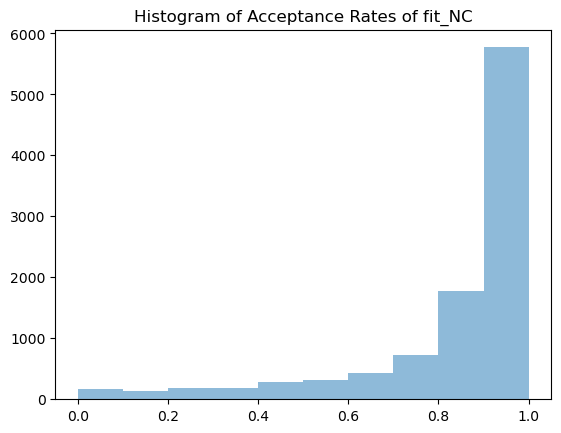

In [120]:
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of fit_NC');

##### The distribution of acceptance rates is very much left-skewed indicating there is a very high probability of acceptance. There isn't a left tail spike at 0 this time, as very little samples have diverged. 

## Energy Function and Curvature

##### 
- In the Eight Schools example, the choice of parameterization can significantly affect the performance of HMC. The centered parameterization directly models the group-level effects , $\theta$, using the hyperparameters $\mu$ and $\tau$. When $\tau$ is close to zero, indicating small between-group variance, the $\theta$ parameters become strongly correlated and the posterior distribution becomes very peaked. This creates regions of high curvature in the energy function, which HMC can struggle with because small changes in $\theta$ can lead to large changes in the log joint posterior density, and hence in the energy function. This can cause HMC to take very small steps, resulting in inefficient sampling and poor mixing between chains.

- The uncentered parameterization can help to alleviate these problems by reparameterizing the model in a way that reduces the dependence between $\theta$ and $\tau$. Instead of sampling $\theta$ directly, you parameterize it by introducing auxiliary variables, which are independent standard normals. It represents the deviation of the mean $\mu$, scaled by $\tau$. This transformation separates $\theta$ from $\tau$ in the model's parameterization, leading to a posterior distribution with less curvature in the energy function. Consequently, HMC can propose larger steps and explore the posterior distribution more efficiently, resulting in better mixing and convergence.

- Thus the uncentered parameterization often performs better for hierarchical models in HMC algorithms because it reduces the curvature of the energy function by decoupling the parameters, leading to more effective exploration of the posterior distribution.

## Diagnostic Plots

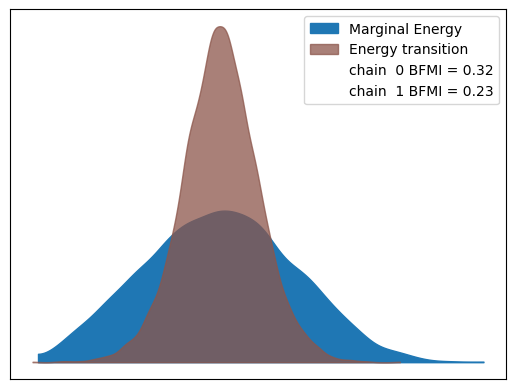

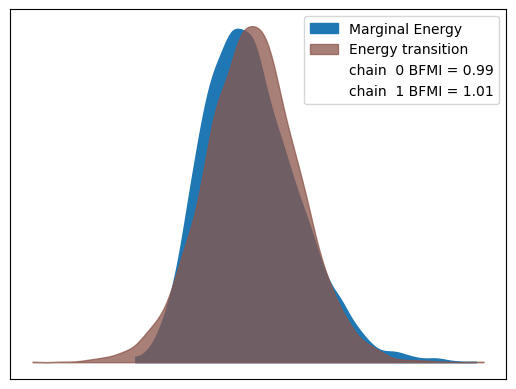

In [121]:
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

##### These energy plots confirm the previous statement that the uncentered parametrization typically performs better in terms of sampling efficiency when using HMC. The improved BFMI (Bayesian Fraction of Missing Information) values and the closer overlap of the energy distributions in the uncentered case imply that the uncentered parametrization has a more favorable geometry for HMC exploration, leading to more effective sampling and convergence. In the centered model, the energy transition density does not align with the marginal energy, which means that HMC did not explore the posterior distribution effectivey. 